In [135]:
import pandas as pd 
import sqlalchemy as sql
import alpaca_trade_api as tradeapi 
import os
from dotenv import load_dotenv 
from pandas_datareader import data  #remember to pip install pandas-datareader
import pandas_datareader as pdr 
import math 
import numpy as np 
import hvplot.pandas
from MCForecastTools import MCSimulation
from pathlib import Path
import pandas_montecarlo

%matplotlib inline 

In [2]:
#downloading data from yahoo (USO, TSLA and SPY)

symbol='USO','TSLA', 'SPY'
start='2010-06-29'
end='2021-10-15'

df=data.get_data_yahoo(symbol, start, end)['Close']
df.head()

Symbols            USO   TSLA         SPY
Date                                     
2010-06-29  273.359985  4.778  104.209999
2010-06-30  271.679993  4.766  103.220001
2010-07-01  262.959991  4.392  102.760002
2010-07-02  260.799988  3.840  102.199997
2010-07-06  260.880005  3.222  102.870003

In [3]:
#creating percent change columns in df

df['USO_pct_change']= df['USO'].pct_change()
df['TSLA_pct_change']= df['TSLA'].pct_change()
df['SPY_pct_change']= df['SPY'].pct_change()



df.describe()


Symbols          USO         TSLA          SPY  USO_pct_change  \
count    2846.000000  2846.000000  2846.000000     2845.000000   
mean      164.771809   106.112510   226.313131       -0.000287   
std       102.387174   189.260934    82.173761        0.022700   
min        17.040001     3.160000   102.199997       -0.253150   
25%        85.120003    10.464000   158.595005       -0.010686   
50%       112.760002    45.909000   209.770004        0.000690   
75%       276.460007    65.295502   279.069992        0.011073   
max       361.200012   883.090027   453.190002        0.166667   

Symbols  TSLA_pct_change  SPY_pct_change  
count        2845.000000     2845.000000  
mean            0.002437        0.000568  
std             0.035274        0.010644  
min            -0.210628       -0.109424  
25%            -0.014816       -0.003469  
50%             0.001255        0.000649  
75%             0.019081        0.005452  
max             0.243951        0.090603

In [4]:
# Working with SQL in order to not ping the Yahoo too much  
#Creating SQL connection/engine

database_connection_string = 'sqlite:///'
engine = sql.create_engine(database_connection_string)
engine

Engine(sqlite:///)

In [5]:
#shoving closing_prices_df from Yahoo into a SQL Table 

df.to_sql('closing_prices', engine, index= True, if_exists='replace' )


In [6]:
#Code to grab the data from the SQL table into a pandas df to analyze further 

closing_prices_df = pd.read_sql_table ('closing_prices', con=engine)


In [7]:
closing_prices_df.describe()

USO         TSLA          SPY  USO_pct_change  TSLA_pct_change  \
count  2846.000000  2846.000000  2846.000000     2845.000000      2845.000000   
mean    164.771809   106.112510   226.313131       -0.000287         0.002437   
std     102.387174   189.260934    82.173761        0.022700         0.035274   
min      17.040001     3.160000   102.199997       -0.253150        -0.210628   
25%      85.120003    10.464000   158.595005       -0.010686        -0.014816   
50%     112.760002    45.909000   209.770004        0.000690         0.001255   
75%     276.460007    65.295502   279.069992        0.011073         0.019081   
max     361.200012   883.090027   453.190002        0.166667         0.243951   

       SPY_pct_change  
count     2845.000000  
mean         0.000568  
std          0.010644  
min         -0.109424  
25%         -0.003469  
50%          0.000649  
75%          0.005452  
max          0.090603

In [8]:
closing_prices_df.head()

Date         USO   TSLA         SPY  USO_pct_change  TSLA_pct_change  \
0 2010-06-29  273.359985  4.778  104.209999             NaN              NaN   
1 2010-06-30  271.679993  4.766  103.220001       -0.006146        -0.002512   
2 2010-07-01  262.959991  4.392  102.760002       -0.032097        -0.078472   
3 2010-07-02  260.799988  3.840  102.199997       -0.008214        -0.125683   
4 2010-07-06  260.880005  3.222  102.870003        0.000307        -0.160938   

   SPY_pct_change  
0             NaN  
1       -0.009500  
2       -0.004456  
3       -0.005450  
4        0.006556

In [9]:
#calcualting correlations between assets 

df_correlation=closing_prices_df[['USO_pct_change', 'TSLA_pct_change', 'SPY_pct_change']]
df_correlation.corr (method='pearson')

USO_pct_change  TSLA_pct_change  SPY_pct_change
USO_pct_change         1.000000         0.196624        0.398108
TSLA_pct_change        0.196624         1.000000        0.393186
SPY_pct_change         0.398108         0.393186        1.000000

In [10]:
df_correlation_first_700 = df_correlation[:700]
df_correlation_1100_1400 = df_correlation[1100:1400]
df_correlation_2400_2500 = df_correlation[2400:2500]
df_correlation_2500 = df_correlation[2500:]


In [11]:

print('Correlation for the first 700 days')
display(df_correlation_first_700.corr(method='pearson'))
print ('Correlation for days 1100 - 1400')
display(df_correlation_1100_1400.corr(method='pearson'))
print('Correlation for days 2400-2500')
display(df_correlation_2400_2500.corr(method='pearson'))
print('Correlation after 2500')
display(df_correlation_2500.corr(method='pearson'))
print('Whole data set')
df_correlation.corr (method='pearson')

Correlation for the first 700 days


USO_pct_change  TSLA_pct_change  SPY_pct_change
USO_pct_change         1.000000         0.265759        0.572316
TSLA_pct_change        0.265759         1.000000        0.388257
SPY_pct_change         0.572316         0.388257        1.000000

Correlation for days 1100 - 1400


USO_pct_change  TSLA_pct_change  SPY_pct_change
USO_pct_change         1.000000         0.199390        0.324372
TSLA_pct_change        0.199390         1.000000        0.490492
SPY_pct_change         0.324372         0.490492        1.000000

Correlation for days 2400-2500


USO_pct_change  TSLA_pct_change  SPY_pct_change
USO_pct_change         1.000000         0.318407        0.404437
TSLA_pct_change        0.318407         1.000000        0.521912
SPY_pct_change         0.404437         0.521912        1.000000

Correlation after 2500


USO_pct_change  TSLA_pct_change  SPY_pct_change
USO_pct_change         1.000000         0.171341        0.402591
TSLA_pct_change        0.171341         1.000000        0.446240
SPY_pct_change         0.402591         0.446240        1.000000

Whole data set


USO_pct_change  TSLA_pct_change  SPY_pct_change
USO_pct_change         1.000000         0.196624        0.398108
TSLA_pct_change        0.196624         1.000000        0.393186
SPY_pct_change         0.398108         0.393186        1.000000

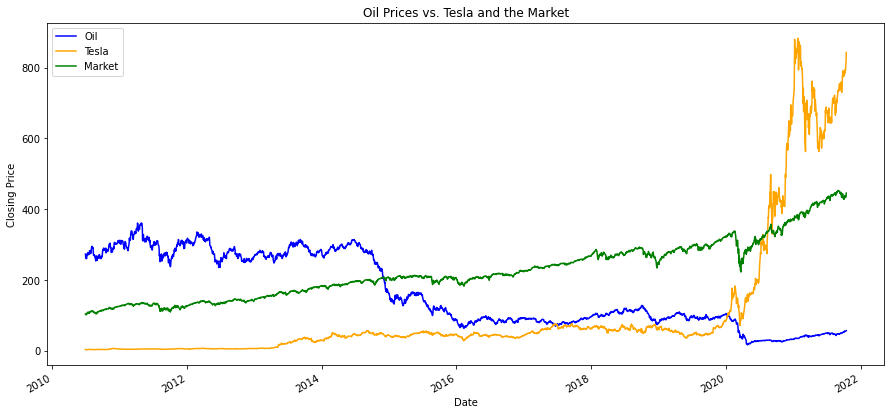

In [12]:
###Start of Kinika 

#This is an overlay plot of the closing prices of the three tickers for the whole dataset
closing_prices_df = closing_prices_df.set_index("Date")

closing_prices_df['USO'].plot(legend=True, figsize=(15, 7), title="Oil Prices vs. Tesla and the Market", color="blue", label="Oil", xlabel="Date", ylabel ="Closing Price")
closing_prices_df['TSLA'].plot(legend=True, figsize=(15, 7), color="orange", label="Tesla")
closing_prices_df['SPY'].plot(legend=True, figsize=(15, 7), color="green", label="Market");

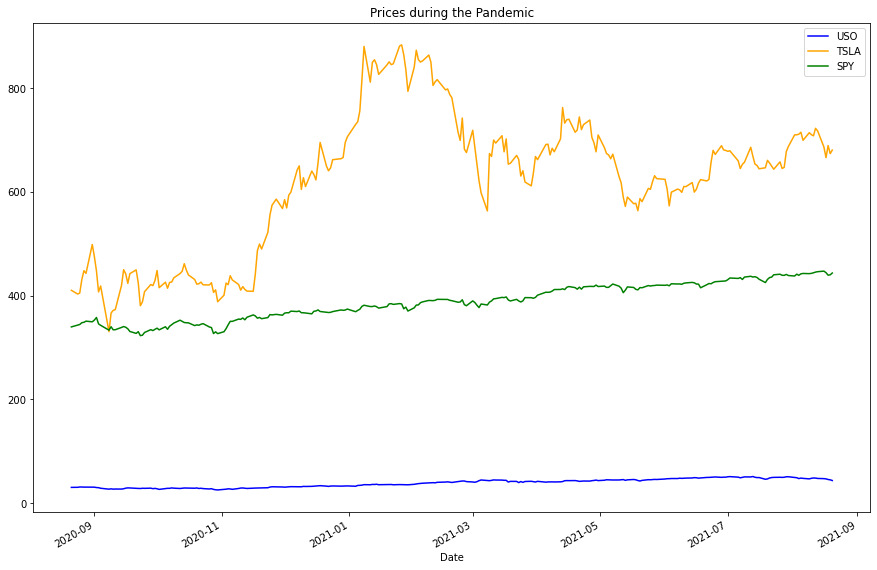

In [13]:
#This will show an overlay plot for the three different tickers on the time period chosen
#This is an interesting time frame as it showed a rapid growth in TSLA.
closing_prices_df['USO'].loc['2020-08-21' : '2021-08-21'].plot(
    legend=True, figsize=(15, 10), title= "Prices during the Pandemic", color="blue", label="USO")
closing_prices_df['TSLA'].loc['2020-08-21' : '2021-08-21'].plot(
    legend=True, figsize=(15, 10), color= "orange", label="TSLA")
closing_prices_df['SPY'].loc['2020-08-21' : '2021-08-21'].plot(
    legend=True, figsize=(15, 10), color="green", label="SPY");

In [14]:
# Calculate the daily return for TSLA using the 'pct_change()' function
daily_returns_TSLA = closing_prices_df["TSLA"].pct_change()

# Review the daily_returns TSLA DataFrame using pctchange function
daily_returns_TSLA.describe()

count    2845.000000
mean        0.002437
std         0.035274
min        -0.210628
25%        -0.014816
50%         0.001255
75%         0.019081
max         0.243951
Name: TSLA, dtype: float64

In [15]:
# Calculating daily return for a 1 year period
daily_returns_1_year_TSLA = daily_returns_TSLA.loc["2020-08-21":"2021-08-21"]

# Display 1 year return statistics
daily_returns_1_year_TSLA.describe()

count    252.000000
mean       0.002946
std        0.041026
min       -0.210628
25%       -0.020288
50%        0.001733
75%        0.024151
max        0.196412
Name: TSLA, dtype: float64

In [16]:
# Calculating daily return for a 5 year period
daily_returns_5_year_TSLA = daily_returns_TSLA.loc["2016-08-21":"2021-08-21"]

# Display 5 year return statistics
daily_returns_5_year_TSLA.describe()

count    1259.000000
mean        0.002852
std         0.037336
min        -0.210628
25%        -0.015237
50%         0.001267
75%         0.019401
max         0.198949
Name: TSLA, dtype: float64

In [17]:

# Calculate the cumulative returns using the 'cumprod()' function
cumulative_returns_TSLA = (1 + daily_returns_TSLA).cumprod()
cumulative_returns_TSLA.head()

Date
2010-06-29         NaN
2010-06-30    0.997488
2010-07-01    0.919213
2010-07-02    0.803684
2010-07-06    0.674341
Name: TSLA, dtype: float64

In [18]:
cumulative_returns_5_year_TSLA = (1 + daily_returns_5_year_TSLA).cumprod()
cumulative_returns_5_year_TSLA.head()

Date
2016-08-22    0.990800
2016-08-23    0.999289
2016-08-24    0.989422
2016-08-25    0.982044
2016-08-26    0.977733
Name: TSLA, dtype: float64

In [19]:

cumulative_returns_1_year_TSLA = (1 + daily_returns_1_year_TSLA).cumprod()
cumulative_returns_1_year_TSLA.head()

Date
2020-08-21    1.024053
2020-08-24    1.006179
2020-08-25    1.010745
2020-08-26    1.075601
2020-08-27    1.118352
Name: TSLA, dtype: float64

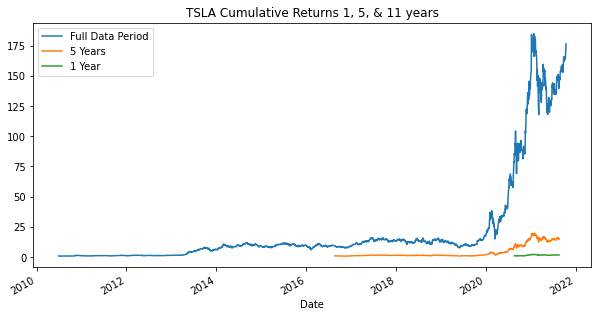

In [20]:
#Graph cumulative returns for TSLA across full data period, 5 years and 1 year
ax = cumulative_returns_TSLA.plot(
    legend="True",
    figsize=(10,5),
    title="TSLA Cumulative Returns 1, 5, & 11 years")
cumulative_returns_5_year_TSLA.plot(ax=ax)
cumulative_returns_1_year_TSLA.plot(ax=ax)

ax.legend(["Full Data Period", "5 Years", "1 Year"]);

In [21]:
# Calculate the daily return for USO using the 'pct_change()' function
daily_returns_USO = closing_prices_df["USO"].pct_change()

# Review the daily_returns USO DataFrame using pctchange function
daily_returns_USO.head()

Date
2010-06-29         NaN
2010-06-30   -0.006146
2010-07-01   -0.032097
2010-07-02   -0.008214
2010-07-06    0.000307
Name: USO, dtype: float64

In [22]:
# Calculating daily return for a 1 year period
daily_returns_1_year_USO = daily_returns_USO.loc["2020-08-21":"2021-08-21"]

# Display 1 year return statistics
daily_returns_1_year_USO.describe()

count    252.000000
mean       0.001613
std        0.020589
min       -0.076449
25%       -0.009731
50%        0.002923
75%        0.014597
max        0.060446
Name: USO, dtype: float64

In [23]:

# Calculating daily return for a 5 year period
daily_returns_5_year_USO = daily_returns_USO.loc["2016-08-21":"2021-08-21"]

# Display 5 year return statistics
daily_returns_5_year_USO.describe()

count    1259.000000
mean       -0.000234
std         0.026032
min        -0.253150
25%        -0.010710
50%         0.001391
75%         0.012021
max         0.166667
Name: USO, dtype: float64

In [24]:

cumulative_returns_USO = (1 + daily_returns_USO).cumprod()
cumulative_returns_USO.head()

Date
2010-06-29         NaN
2010-06-30    0.993854
2010-07-01    0.961955
2010-07-02    0.954053
2010-07-06    0.954346
Name: USO, dtype: float64

In [25]:
cumulative_returns_5_year_USO = (1 + daily_returns_5_year_USO).cumprod()
cumulative_returns_5_year_USO.head()

Date
2016-08-22    0.967372
2016-08-23    0.977954
2016-08-24    0.954145
2016-08-25    0.965608
2016-08-26    0.965608
Name: USO, dtype: float64

In [26]:
cumulative_returns_1_year_USO = (1 + daily_returns_1_year_USO).cumprod()
cumulative_returns_1_year_USO.head()

Date
2020-08-21    0.988860
2020-08-24    0.994430
2020-08-25    1.013106
2020-08-26    1.013434
2020-08-27    1.004915
Name: USO, dtype: float64

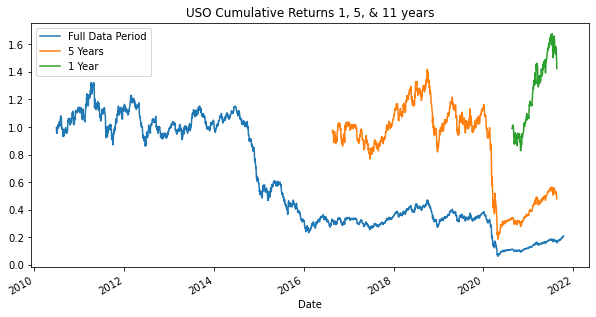

In [27]:

#Graph cumulative returns for USO across full data period, 5 years and 1 year
ax = cumulative_returns_USO.plot(
    legend="True",
    figsize=(10,5),
    title="USO Cumulative Returns 1, 5, & 11 years")
cumulative_returns_5_year_USO.plot(ax=ax)
cumulative_returns_1_year_USO.plot(ax=ax)

ax.legend(["Full Data Period", "5 Years", "1 Year"]);

In [28]:

closing_prices_df.head()

USO   TSLA         SPY  USO_pct_change  TSLA_pct_change  \
Date                                                                         
2010-06-29  273.359985  4.778  104.209999             NaN              NaN   
2010-06-30  271.679993  4.766  103.220001       -0.006146        -0.002512   
2010-07-01  262.959991  4.392  102.760002       -0.032097        -0.078472   
2010-07-02  260.799988  3.840  102.199997       -0.008214        -0.125683   
2010-07-06  260.880005  3.222  102.870003        0.000307        -0.160938   

            SPY_pct_change  
Date                        
2010-06-29             NaN  
2010-06-30       -0.009500  
2010-07-01       -0.004456  
2010-07-02       -0.005450  
2010-07-06        0.006556

In [29]:
daily_returns_df=closing_prices_df.drop(columns = ["USO","TSLA","SPY"], axis=1)
daily_returns_df.head()
#daily_returns_df.plot(figsize=(20,10),title ="Percent Change over time")

USO_pct_change  TSLA_pct_change  SPY_pct_change
Date                                                       
2010-06-29             NaN              NaN             NaN
2010-06-30       -0.006146        -0.002512       -0.009500
2010-07-01       -0.032097        -0.078472       -0.004456
2010-07-02       -0.008214        -0.125683       -0.005450
2010-07-06        0.000307        -0.160938        0.006556

In [30]:

# Calculate the standard deviation for each of the tech stocks
# call the Pandas `std` function on the `daily_returns` DataFrame
standard_deviation = daily_returns_df.std()

# Display results
standard_deviation.head()

USO_pct_change     0.022700
TSLA_pct_change    0.035274
SPY_pct_change     0.010644
dtype: float64

In [31]:
# Sort the standard deviation values using Pandas 'sort_values' function
standard_deviation_sorted = standard_deviation.sort_values()

# Display results
standard_deviation_sorted

#Here we can see TSLA has the largest standard deviation which means it's the most risky 
#stock whereas SPY has the lowest standard deviation indicating the least risky stock

SPY_pct_change     0.010644
USO_pct_change     0.022700
TSLA_pct_change    0.035274
dtype: float64

In [32]:
# Calculate the annualized standard deviation, using the standard_deviation
# from the daily_returns DataFrame multiplied by the square root (np.sqrt)
# of the number of trading days in a year (252)
annualized_standard_deviation = standard_deviation * np.sqrt(252)

# Display the sorted results
annualized_standard_deviation.sort_values()

SPY_pct_change     0.168969
USO_pct_change     0.360346
TSLA_pct_change    0.559959
dtype: float64

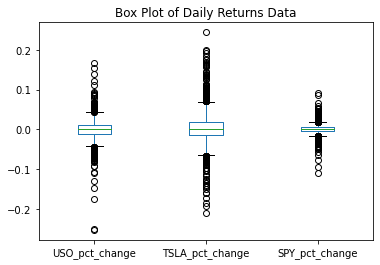

In [33]:
# Plot box plot
#This confirms that TSLA is the most volatile as it has the longest whiskers and had some outlier
#which is the same confirmation from analyzing standard deviation. 
daily_returns_df.plot.box(title ="Box Plot of Daily Returns Data");

In [34]:
# Set the number of trading days for the year
year_trading_days = 252

# To calculate the annualized average return of portfolio,
# calculate the mean of the daily return values for each stock in 'portfolio'
# and then multiply that by the number of trading days in the year
average_annual_return_portfolio= daily_returns_df.mean() * year_trading_days

# Display the average annual return values for each stock in 'portfolio'
average_annual_return_portfolio

USO_pct_change    -0.072343
TSLA_pct_change    0.614237
SPY_pct_change     0.143129
dtype: float64

In [35]:

# Calculate the annualized standard deviation, using the standard_deviation
# from the daily_returns DataFrame multiplied by the square root (np.sqrt)
# of the number of trading days in a year (252)
annualized_standard_deviation = standard_deviation * np.sqrt(252)

# Display the sorted results
annualized_standard_deviation.sort_values()

SPY_pct_change     0.168969
USO_pct_change     0.360346
TSLA_pct_change    0.559959
dtype: float64

In [36]:
# Calculate Sharpe Ratio by dividing the average annual return by the standard deviation
sharpe_ratios = average_annual_return_portfolio / annualized_standard_deviation
# Display sorted results
sharpe_ratios.sort_values()

USO_pct_change    -0.200759
SPY_pct_change     0.847074
TSLA_pct_change    1.096933
dtype: float64

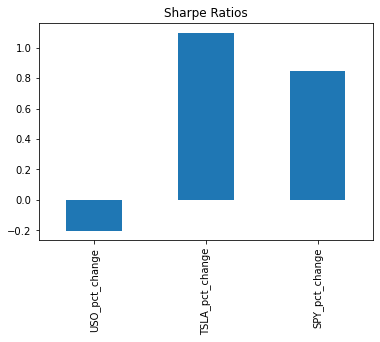

In [37]:
sharpe_ratios.plot.bar(title="Sharpe Ratios");

In [38]:
#Calculating TSLA Beta
daily_returns_TSLA_SPY=daily_returns_df.drop(columns = ["USO_pct_change"], axis=1)
daily_returns_TSLA_SPY.head()

TSLA_pct_change  SPY_pct_change
Date                                       
2010-06-29              NaN             NaN
2010-06-30        -0.002512       -0.009500
2010-07-01        -0.078472       -0.004456
2010-07-02        -0.125683       -0.005450
2010-07-06        -0.160938        0.006556

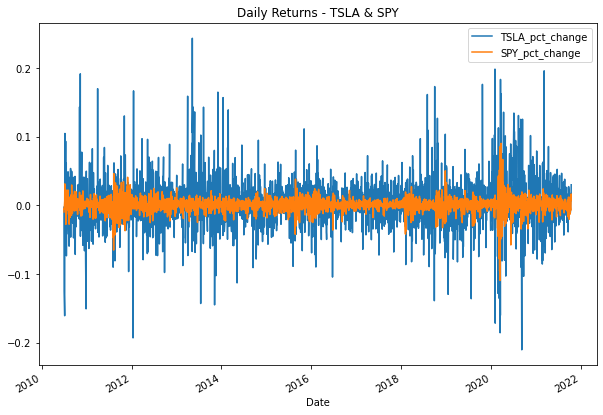

In [39]:
# Plotting the daily returns for TSLA and the SPY
daily_returns_TSLA_SPY.plot(figsize=(10, 7), title="Daily Returns - TSLA & SPY");

In [40]:
# Using the Pandas 'var' function, calculate the variance of TSLA and SPY
daily_returns_TSLA_SPY.var()

TSLA_pct_change    0.001244
SPY_pct_change     0.000113
dtype: float64

In [41]:
# Calculate covariance of all daily returns of TSLA vs. SPY
covariance_TSLA = daily_returns_TSLA_SPY['TSLA_pct_change'].cov(daily_returns_TSLA_SPY['SPY_pct_change'])

# Display the covariance
print(f"{covariance_TSLA: .8f} ")

 0.00014763 


In [42]:

# Calculate beta of all daily returns of TSLA
# Divide the covariance of TSLA versus SPY by the variance of SPY
TSLA_beta = daily_returns_TSLA_SPY['TSLA_pct_change'].cov(daily_returns_TSLA_SPY['SPY_pct_change']) / daily_returns_TSLA_SPY["SPY_pct_change"].var()

# Display the TSLA$ beta
TSLA_beta

1.3030067874364868

In [43]:
#Calculating USO Beta
daily_returns_USO_SPY=daily_returns_df.drop(columns = ["TSLA_pct_change"], axis=1)
daily_returns_USO_SPY.head()

USO_pct_change  SPY_pct_change
Date                                      
2010-06-29             NaN             NaN
2010-06-30       -0.006146       -0.009500
2010-07-01       -0.032097       -0.004456
2010-07-02       -0.008214       -0.005450
2010-07-06        0.000307        0.006556

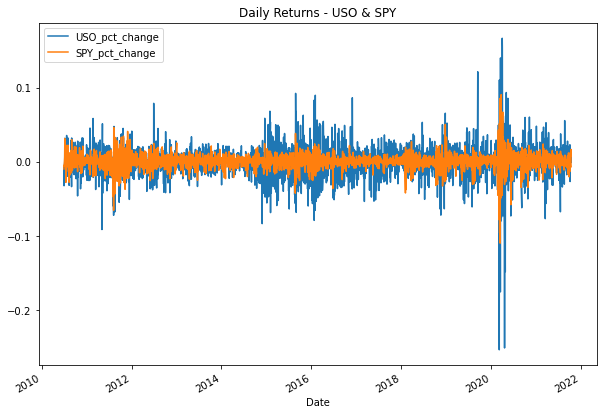

In [44]:
# Plotting the daily returns for USO and the SPY
daily_returns_USO_SPY.plot(figsize=(10, 7), title="Daily Returns - USO & SPY");

In [45]:
# Using the Pandas 'var' function, calculate the variance of USO and SPY
daily_returns_USO_SPY.var()

USO_pct_change    0.000515
SPY_pct_change    0.000113
dtype: float64

In [46]:

# Calculate covariance of all daily returns of USO vs. SPY
covariance_USO = daily_returns_USO_SPY['USO_pct_change'].cov(daily_returns_USO_SPY['SPY_pct_change'])

# Display the covariance
print(f"{covariance_USO: .8f} ")

 0.00009619 


In [47]:
# Calculate beta of all daily returns of USO
# Divide the covariance of USO versus SPY by the variance of SPY
USO_beta = daily_returns_USO_SPY['USO_pct_change'].cov(daily_returns_USO_SPY['SPY_pct_change']) / daily_returns_USO_SPY["SPY_pct_change"].var()

# Display the USO beta
USO_beta

0.8490111831604793

In [48]:
# Creating a DataFrame for only closing prices
closing_prices_only_df = closing_prices_df.drop(columns=['USO_pct_change' , 'TSLA_pct_change' , 'SPY_pct_change'])

In [49]:

# This chart shows the price changes since TSLA IPO
closing_prices_only_df.hvplot.line(
    xlabel="Trading Days",
    ylabel="Closing Price",
    title="Price Change Since TSLA IPO",
    height=500,
    width=1000
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [50]:

# Creating a DataFrame for only percentage change only
percent_change_only_df = closing_prices_df.drop(columns=['USO' , 'TSLA' , 'SPY'])

In [51]:
percent_change_only_df.head()


USO_pct_change  TSLA_pct_change  SPY_pct_change
Date                                                       
2010-06-29             NaN              NaN             NaN
2010-06-30       -0.006146        -0.002512       -0.009500
2010-07-01       -0.032097        -0.078472       -0.004456
2010-07-02       -0.008214        -0.125683       -0.005450
2010-07-06        0.000307        -0.160938        0.006556

In [52]:
percent_change_only_df.tail()

USO_pct_change  TSLA_pct_change  SPY_pct_change
Date                                                       
2021-10-11        0.012800         0.008211       -0.007240
2021-10-12       -0.001246         0.017400       -0.002462
2021-10-13        0.000891         0.006652        0.003598
2021-10-14        0.011574         0.008926        0.016821
2021-10-15        0.005985         0.030196        0.007616

In [53]:
percent_change_only_df.describe()

USO_pct_change  TSLA_pct_change  SPY_pct_change
count     2845.000000      2845.000000     2845.000000
mean        -0.000287         0.002437        0.000568
std          0.022700         0.035274        0.010644
min         -0.253150        -0.210628       -0.109424
25%         -0.010686        -0.014816       -0.003469
50%          0.000690         0.001255        0.000649
75%          0.011073         0.019081        0.005452
max          0.166667         0.243951        0.090603

In [54]:
# This chart shows percentage changes since TSLA IPO
percent_change_only_df.hvplot.line(
    xlabel="Trading Days",
    ylabel="Percent Change x 100",
    title="Daily Percent Change Since TSLA IPO",
    height=500,
    width=1000
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [55]:
# Creating a cumulative return dataframe
cumulative_returns_df = percent_change_only_df.cumsum()

In [56]:
cumulative_returns_df

USO_pct_change  TSLA_pct_change  SPY_pct_change
Date                                                       
2010-06-29             NaN              NaN             NaN
2010-06-30       -0.006146        -0.002512       -0.009500
2010-07-01       -0.038242        -0.080984       -0.013957
2010-07-02       -0.046456        -0.206667       -0.019406
2010-07-06       -0.046150        -0.367605       -0.012850
...                    ...              ...             ...
2021-10-11       -0.833929         6.871364        1.590312
2021-10-12       -0.835175         6.888764        1.587850
2021-10-13       -0.834284         6.895416        1.591448
2021-10-14       -0.822710         6.904343        1.608269
2021-10-15       -0.816725         6.934539        1.615884

[2846 rows x 3 columns]

In [57]:
cumulative_returns_df.dropna()

USO_pct_change  TSLA_pct_change  SPY_pct_change
Date                                                       
2010-06-30       -0.006146        -0.002512       -0.009500
2010-07-01       -0.038242        -0.080984       -0.013957
2010-07-02       -0.046456        -0.206667       -0.019406
2010-07-06       -0.046150        -0.367605       -0.012850
2010-07-07       -0.014258        -0.386847        0.018646
...                    ...              ...             ...
2021-10-11       -0.833929         6.871364        1.590312
2021-10-12       -0.835175         6.888764        1.587850
2021-10-13       -0.834284         6.895416        1.591448
2021-10-14       -0.822710         6.904343        1.608269
2021-10-15       -0.816725         6.934539        1.615884

[2845 rows x 3 columns]

In [58]:
# This chart shows cumulative returns since TSLA IPO
cumulative_returns_df.hvplot.line(
    xlabel="Trading Days",
    ylabel="Percent Change x 100",
    title="Cumulative Returns Since TSLA IPO",
    height=500,
    width=1000
)

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [59]:
#Start of MC 

In [60]:
# Load the environment variables from the .env file
#by calling the load_dotenv function
alpaca_api_key = "PKNNM45CLK9LPCYRZ4CI"
alpaca_secret_key = "lbEbqDT7yDybpVPkVRCCGeR1kd0tuj4hBJ93KL5u"

alpaca = tradeapi.REST(
    alpaca_api_key,
    alpaca_secret_key,
    api_version="v2"
)

In [61]:
# Set the tickers for both the bond and stock portion of the portfolio
tickers = ["TSLA"]
# Set timeframe to 1D 
timeframe = "1D"

# Format current date as ISO format
# Set both the start and end date at the date of your prior weekday 
# This will give you the closing price of the previous trading day
# Alternatively you can use a start and end date of 2020-08-07
start_date = pd.Timestamp("2010-11-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-11-01", tz="America/New_York").isoformat()


In [62]:
# Use the Alpaca get_barset function to get current closing prices the portfolio
# Be sure to set the `df` property after the function to format the response object as a DataFrame
df_portfolio = alpaca.get_barset(
    tickers,
    timeframe, 
    start = start_date,
    end = end_date
).df

# Review the first 5 rows of the Alpaca DataFrame
df_portfolio.tail()

TSLA                                      
                              open     high       low    close    volume
time                                                                    
2021-10-26 00:00:00-04:00  1024.70  1094.94  1001.440  1018.06  60207022
2021-10-27 00:00:00-04:00  1038.78  1070.88  1030.780  1038.00  35678056
2021-10-28 00:00:00-04:00  1068.03  1081.00  1054.200  1077.09  24517641
2021-10-29 00:00:00-04:00  1081.41  1115.21  1073.205  1114.18  27215436
2021-11-01 00:00:00-04:00  1145.01  1209.75  1118.660  1209.48  51136101

In [63]:
# Access the closing price for AGG from the Alpaca DataFrame
# Converting the value to a floating point number
tsla_close_price = df_portfolio["TSLA"]["close"]
tsla_close_price


time
2021-06-11 00:00:00-04:00     609.89
2021-06-14 00:00:00-04:00     617.69
2021-06-15 00:00:00-04:00     599.20
2021-06-16 00:00:00-04:00     604.79
2021-06-17 00:00:00-04:00     616.60
                              ...   
2021-10-26 00:00:00-04:00    1018.06
2021-10-27 00:00:00-04:00    1038.00
2021-10-28 00:00:00-04:00    1077.09
2021-10-29 00:00:00-04:00    1114.18
2021-11-01 00:00:00-04:00    1209.48
Name: close, Length: 100, dtype: float64

In [64]:
# Set start and end dates of 3 years back from your current date
# Alternatively, you can use an end date of 2020-08-07 and work 3 years back from that date 
#look at 5.3.3 in the lesson for help
#start_date = pd.Timestamp("2010-11-01", tz="America/New_York").isoformat()
#end_date = pd.Timestamp("2021-11-01", tz="America/New_York").isoformat()


# Set number of rows to 1000 to retrieve the maximum amount of rows
limit_rows = 1000

In [65]:
# Use the Alpaca get_barset function to make the API call to get the 3 years worth of pricing data
# The tickers and timeframe parameters should have been set in Part 1 of this activity 
# The start and end dates should be updated with the information set above
# Remember to add the df property to the end of the call so the response is returned as a DataFrame
prices_df = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date,
    limit = limit_rows
).df


# Display both the first and last five rows of the DataFrame
prices_df.head()

TSLA                                 
                             open    high     low   close   volume
time                                                              
2017-11-10 00:00:00-05:00  302.50  308.36  301.85  302.92  3603353
2017-11-13 00:00:00-05:00  300.13  316.80  299.11  315.40  6019636
2017-11-14 00:00:00-05:00  314.43  316.35  306.90  308.70  4567972
2017-11-15 00:00:00-05:00  306.01  312.49  301.50  311.25  4800540
2017-11-16 00:00:00-05:00  313.99  318.14  311.30  312.50  4394695

In [66]:
# Configure the Monte Carlo simulation to forecast 30 years cumulative returns
# Run 500 samples.
MC_five = MCSimulation(
    portfolio_data= prices_df,
    weights=[1],
    num_simulation= 500,
    num_trading_days= 252 * 5
)

MC_five.portfolio_data.head()


TSLA                                   \
                             open    high     low   close   volume   
time                                                                 
2017-11-10 00:00:00-05:00  302.50  308.36  301.85  302.92  3603353   
2017-11-13 00:00:00-05:00  300.13  316.80  299.11  315.40  6019636   
2017-11-14 00:00:00-05:00  314.43  316.35  306.90  308.70  4567972   
2017-11-15 00:00:00-05:00  306.01  312.49  301.50  311.25  4800540   
2017-11-16 00:00:00-05:00  313.99  318.14  311.30  312.50  4394695   

                                        
                          daily_return  
time                                    
2017-11-10 00:00:00-05:00          NaN  
2017-11-13 00:00:00-05:00     0.041199  
2017-11-14 00:00:00-05:00    -0.021243  
2017-11-15 00:00:00-05:00     0.008260  
2017-11-16 00:00:00-05:00     0.004016

In [67]:
# Run the Monte Carlo simulation to forecast 5 years cumulative returns
MC_five.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0         1          2          3          4         5         6    \
0     1.000000  1.000000   1.000000   1.000000   1.000000  1.000000  1.000000   
1     0.928024  0.990997   0.924071   1.015617   1.118388  0.958164  0.987017   
2     0.881935  0.905063   0.905292   0.972481   1.111659  1.031438  1.026190   
3     0.885449  0.894470   0.855103   0.965260   0.997599  1.071713  1.028028   
4     0.897935  0.900098   0.887799   1.011652   1.086397  1.062222  1.068443   
...        ...       ...        ...        ...        ...       ...       ...   
1256  0.711953  0.208521  16.109646  24.970495  20.408845  7.245472  4.234198   
1257  0.673571  0.188492  14.785263  26.745883  19.661010  7.341330  4.077716   
1258  0.656132  0.181944  14.027422  27.014677  21.021945  7.196782  3.790347   
1259  0.690162  0.186895  13.483622  25.492948  20.171449  6.505674  3.726229   
1260  0.661632  0.182898  13.670355  25.262564  19.963178  6.219955  3.534349   

            7         8          9    ...        490       491       492  \
0      1.000000  1.000000   1.000000  ...   1.000000  1.000000  1.000000   
1      1.024396  0.976769   0.960370  ...   1.106799  1.023236  1.011385   
2      1.075437  1.019559   0.976015  ...   1.140166  1.007163  1.037591   
3      1.106990  0.957535   1.028914  ...   1.198228  0.995410  1.061084   
4      1.090002  0.992881   1.030620  ...   1.134209  1.027530  1.100242   
...         ...       ...        ...  ...        ...       ...       ...   
1256  11.847334  4.160223  28.129267  ...  33.446065  4.558295  1.309302   
1257  11.405965  4.323712  29.677327  ...  34.272826  5.111671  1.268869   
1258  11.929322  3.922391  27.984146  ...  36.505716  5.356320  1.275450   
1259  11.786923  3.877699  28.233846  ...  39.593806  5.703599  1.349979   
1260  11.208507  3.785232  27.012087  ...  40.684078  5.532736  1.360768   

           493        494        495       496        497       498        499  
0     1.000000   1.000000   1.000000  1.000000   1.000000  1.000000   1.000000  
1     0.997129   1.033739   1.092908  0.956379   1.045568  1.018806   0.966853  
2     1.051112   1.018646   1.106520  0.918238   1.088058  1.027493   1.058907  
3     1.049084   1.070750   1.083744  0.919536   1.038259  0.998988   1.043482  
4     1.046396   1.125660   1.130568  0.906845   1.039415  0.976070   1.094406  
...        ...        ...        ...       ...        ...       ...        ...  
1256  6.909518  41.332267  56.877737  9.265023  14.178059  2.254497  27.365951  
1257  6.624045  39.006759  53.742665  9.004497  14.930257  2.381602  27.700541  
1258  6.441914  38.283549  54.290252  9.370031  15.672890  2.286814  28.967399  
1259  6.276683  34.487420  55.215953  8.783529  15.776276  2.291641  28.660405  
1260  6.213401  37.085999  54.568438  9.583178  16.045915  2.073099  28.637409  

[1261 rows x 500 columns]

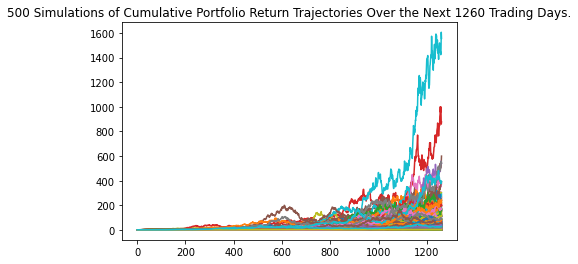

In [69]:
# Visualize the 5-year Monte Carlo simulation by creating an
# overlay line plot
MC_sim__line_plot = MC_five.plot_simulation()




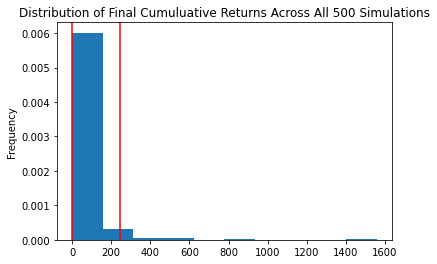

In [70]:
# Visualize the probability distribution of the 5-year Monte Carlo simulation 
# by plotting a histogram
MC_sim_dist_plot = MC_five.plot_distribution()

In [71]:
# Generate summary statistics from the 30-year Monte Carlo simulation results
# Save the results as a variable
MC_summary_statistics = MC_five.summarize_cumulative_return()
MC_summary_statistics


# Review the 30-year Monte Carlo summary statistics
MC_summary_statistics

count            500.000000
mean              39.236376
std              104.098202
min                0.135868
25%                2.990926
50%               10.056570
75%               34.486515
max             1557.064284
95% CI Lower       0.354699
95% CI Upper     244.934705
Name: 1260, dtype: float64

In [73]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the current stock/bond portfolio
ci_lower_five_cumulative_return = MC_summary_statistics[8] * 10000
ci_upper_five_cumulative_return = MC_summary_statistics[9] * 10000

# Print the result of your calculations
print(f"There is a 95% chance that an interval investment of $10,000 in the portfolio"
f" over the next five years will end within the range of "
f" ${ci_lower_five_cumulative_return: .2f} and ${ci_upper_five_cumulative_return: .2f}.")

There is a 95% chance that an interval investment of $10,000 in the portfolio over the next five years will end within the range of  $ 3546.99 and $ 2449347.05.


In [74]:
# Configure a Monte Carlo simulation to forecast 10 years cumulative returns
# The weights should be split 20% to AGG and 80% to SPY.
# Run 500 samples.
MC_tenyear = MCSimulation(
    portfolio_data=prices_df,
    num_simulation=500,
    num_trading_days=252*10
)

# Review the simulation input data
MC_tenyear.portfolio_data.head()


TSLA                                   \
                             open    high     low   close   volume   
time                                                                 
2017-11-10 00:00:00-05:00  302.50  308.36  301.85  302.92  3603353   
2017-11-13 00:00:00-05:00  300.13  316.80  299.11  315.40  6019636   
2017-11-14 00:00:00-05:00  314.43  316.35  306.90  308.70  4567972   
2017-11-15 00:00:00-05:00  306.01  312.49  301.50  311.25  4800540   
2017-11-16 00:00:00-05:00  313.99  318.14  311.30  312.50  4394695   

                                        
                          daily_return  
time                                    
2017-11-10 00:00:00-05:00          NaN  
2017-11-13 00:00:00-05:00     0.041199  
2017-11-14 00:00:00-05:00    -0.021243  
2017-11-15 00:00:00-05:00     0.008260  
2017-11-16 00:00:00-05:00     0.004016

In [75]:
# Run the Monte Carlo simulation to forecast 10 years cumulative returns
MC_tenyear.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0           1         2             3           4           5    \
0       1.000000    1.000000  1.000000      1.000000    1.000000    1.000000   
1       1.058262    0.886039  1.097088      1.021977    0.948909    1.022394   
2       1.015612    0.830136  1.111559      1.040558    0.903660    0.993361   
3       0.948079    0.796209  0.999789      0.993815    0.889291    1.011081   
4       1.064868    0.798935  1.015587      1.000538    0.919606    1.113968   
...          ...         ...       ...           ...         ...         ...   
2516  409.653906   96.674735  1.537200  10514.490998  935.020246  301.959458   
2517  402.605943  100.245010  1.533841  10889.938654  959.831647  317.395592   
2518  420.050845   99.083298  1.568651  11245.023970  887.899892  327.671287   
2519  439.765195  103.651383  1.460836  11703.264765  972.571588  328.437849   
2520  421.150247  105.777611  1.363332  12015.966022  930.236145  327.751459   

              6           7            8           9    ...       490  \
0        1.000000    1.000000     1.000000    1.000000  ...  1.000000   
1        0.998090    0.935203     1.036224    1.003088  ...  1.050419   
2        1.116273    0.962456     1.070051    0.941490  ...  0.970982   
3        1.125930    0.985559     1.033326    0.959235  ...  1.003632   
4        1.176236    0.960313     1.058929    0.934353  ...  0.990058   
...           ...         ...          ...         ...  ...       ...   
2516  3874.868072  771.079930  3018.209969  376.470945  ...  6.721230   
2517  3901.082839  757.304149  3004.309360  357.394342  ...  6.544009   
2518  3754.564102  839.399728  2971.066044  374.779948  ...  6.915508   
2519  3804.184989  830.394102  2825.674284  424.480786  ...  6.637465   
2520  4042.127963  919.089407  2813.021508  431.516991  ...  6.136532   

             491        492          493        494        495         496  \
0       1.000000   1.000000     1.000000   1.000000   1.000000    1.000000   
1       0.980664   1.022440     1.015728   1.060129   1.060375    0.975875   
2       0.981767   1.019142     1.040665   1.026000   1.100182    0.897597   
3       1.096879   1.035389     1.030347   1.080784   1.136706    0.891921   
4       1.127818   1.096780     1.074189   0.997399   1.113437    0.865621   
...          ...        ...          ...        ...        ...         ...   
2516  536.437811  20.216852  1380.779337  37.681695  75.161003  108.644394   
2517  587.743174  20.516232  1397.590745  39.575134  71.684625  116.881841   
2518  585.159842  20.359882  1354.689358  39.518378  72.375782  115.908126   
2519  562.604612  21.164946  1311.597869  39.102163  63.988779  114.147721   
2520  583.853616  20.597130  1412.356313  38.233731  65.618227  117.072496   

             497         498         499  
0       1.000000    1.000000    1.000000  
1       0.985120    0.983074    0.964789  
2       1.012797    0.930604    0.977351  
3       0.968533    0.861881    1.006863  
4       1.029509    0.910105    0.934749  
...          ...         ...         ...  
2516  159.528812  757.509791  626.938844  
2517  159.918769  763.688049  645.559161  
2518  177.688956  761.013265  645.775427  
2519  171.729104  775.629895  644.429368  
2520  169.230133  767.348472  610.706162  

[2521 rows x 500 columns]

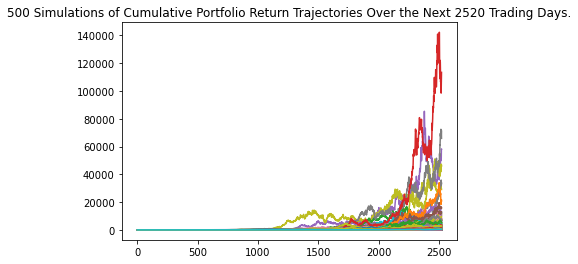

In [76]:
# Visualize the 10-year Monte Carlo simulation by creating an
# overlay line plot
MC_sim__line_plot = MC_tenyear.plot_simulation()

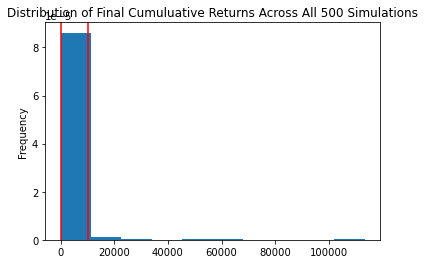

In [77]:
# Visualize the probability distribution of the 10-year Monte Carlo simulation 
# by plotting a histogram
MC_sim__line_plot = MC_tenyear.plot_distribution()


In [78]:
# Generate summary statistics from the 10-year Monte Carlo simulation results
# Save the results as a variable
MC_summary_statistics_ten = MC_tenyear.summarize_cumulative_return()
MC_summary_statistics_ten


# Review the 10-year Monte Carlo summary statistics
MC_summary_statistics_ten

count              500.000000
mean              1504.249133
std               7237.240229
min                  0.313787
25%                 16.969270
50%                107.528435
75%                597.903695
max             113343.447524
95% CI Lower         1.180090
95% CI Upper     10117.011695
Name: 2520, dtype: float64

In [79]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the current stock/bond portfolio
ci_lower_ten_cumulative_return = MC_summary_statistics_ten[8] * 10000
ci_upper_ten_cumulative_return = MC_summary_statistics_ten[9] * 10000

# Print the result of your calculations
print(f"There is a 95% chance that an interval investment of $10,000 in the portfolio"
f" over the next five years will end within the range of "
f" ${ci_lower_ten_cumulative_return: .2f} and ${ci_upper_ten_cumulative_return: .2f}.")

There is a 95% chance that an interval investment of $10,000 in the portfolio over the next five years will end within the range of  $ 11800.90 and $ 101170116.95.


In [80]:
##Oil 


In [81]:
# Set the tickers for both the bond and stock portion of the portfolio
tickers = ["USO"]
# Set timeframe to 1D 
timeframe = "1D"

# Format current date as ISO format
# Set both the start and end date at the date of your prior weekday 
# This will give you the closing price of the previous trading day
# Alternatively you can use a start and end date of 2020-08-07
start_date = pd.Timestamp("2010-11-01", tz="America/New_York").isoformat()
end_date = pd.Timestamp("2021-11-01", tz="America/New_York").isoformat()




In [82]:
# Use the Alpaca get_barset function to get current closing prices the portfolio
# Be sure to set the `df` property after the function to format the response object as a DataFrame
df_portfolio = alpaca.get_barset(
    tickers,
    timeframe, 
    start = start_date,
    end = end_date
).df

# Review the first 5 rows of the Alpaca DataFrame
df_portfolio


USO                                   
                            open    high      low   close    volume
time                                                               
2021-06-11 00:00:00-04:00  47.93  48.250  47.8900  48.070   4206137
2021-06-14 00:00:00-04:00  48.40  48.605  48.0800  48.310   4191256
2021-06-15 00:00:00-04:00  48.68  49.010  48.6300  48.999   4186536
2021-06-16 00:00:00-04:00  48.86  49.460  48.7500  48.750   5966233
2021-06-17 00:00:00-04:00  48.92  49.000  47.3301  48.040  10526931
...                          ...     ...      ...     ...       ...
2021-10-26 00:00:00-04:00  58.08  58.620  57.8710  58.470   3387197
2021-10-27 00:00:00-04:00  57.64  58.170  56.8750  56.890   6431765
2021-10-28 00:00:00-04:00  56.85  57.420  56.3800  57.410   5019324
2021-10-29 00:00:00-04:00  56.79  57.390  56.4020  57.170   4963097
2021-11-01 00:00:00-04:00  57.91  58.040  57.4600  57.530   2434891

[100 rows x 5 columns]

In [83]:
# Access the closing price for AGG from the Alpaca DataFrame
# Converting the value to a floating point number
uso_close_price = df_portfolio

uso_close_price.head()

USO                                   
                            open    high      low   close    volume
time                                                               
2021-06-11 00:00:00-04:00  47.93  48.250  47.8900  48.070   4206137
2021-06-14 00:00:00-04:00  48.40  48.605  48.0800  48.310   4191256
2021-06-15 00:00:00-04:00  48.68  49.010  48.6300  48.999   4186536
2021-06-16 00:00:00-04:00  48.86  49.460  48.7500  48.750   5966233
2021-06-17 00:00:00-04:00  48.92  49.000  47.3301  48.040  10526931

In [84]:
# Use the Alpaca get_barset function to make the API call to get the 3 years worth of pricing data
# The tickers and timeframe parameters should have been set in Part 1 of this activity 
# The start and end dates should be updated with the information set above
# Remember to add the df property to the end of the call so the response is returned as a DataFrame
prices_df = alpaca.get_barset(
    tickers,
    timeframe,
    start = start_date,
    end = end_date,
    limit = limit_rows
).df


# Display both the first and last five rows of the DataFrame
prices_df.head(5)
prices_df.tail(5)



USO                               
                            open   high     low  close   volume
time                                                           
2021-10-26 00:00:00-04:00  58.08  58.62  57.871  58.47  3387197
2021-10-27 00:00:00-04:00  57.64  58.17  56.875  56.89  6431765
2021-10-28 00:00:00-04:00  56.85  57.42  56.380  57.41  5019324
2021-10-29 00:00:00-04:00  56.79  57.39  56.402  57.17  4963097
2021-11-01 00:00:00-04:00  57.91  58.04  57.460  57.53  2434891

In [85]:
# Configure the Monte Carlo simulation to forecast 5 years cumulative returns
# Run 500 samples.
MC_five = MCSimulation(
    portfolio_data= prices_df,
    num_simulation= 500,
    num_trading_days= 252 * 5
)



In [86]:
# Run the Monte Carlo simulation to forecast 5 years cumulative returns
MC_five.calc_cumulative_return()

Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0             1             2             3             4    \
0     1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
1     9.945339e-01  1.083071e+00  1.105803e+00  9.800028e-01  1.232725e+00   
2     1.188945e+00  1.119190e+00  1.128958e+00  8.550653e-01  1.135615e+00   
3     7.663820e-01  1.247587e+00  1.657508e+00  8.715053e-01  1.121235e+00   
4     8.051083e-01  1.405556e+00  1.356211e+00  9.731759e-01  8.676435e-01   
...            ...           ...           ...           ...           ...   
1256  3.347628e-14  2.297943e-11  2.559509e-13  1.306347e-17  2.021903e-19   
1257  2.762126e-14  3.238990e-11  2.252707e-13  1.528235e-17  7.501031e-20   
1258  2.423318e-14  2.968714e-11  2.471177e-13  1.812759e-17  9.899348e-20   
1259  2.871858e-14  2.661962e-11  2.771052e-13  1.952316e-17  1.260484e-19   
1260  2.164556e-14  3.558317e-11  2.002987e-13  1.196249e-17  8.511193e-20   

               5             6             7             8             9    \
0     1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
1     8.109107e-01  1.281130e+00  1.174790e+00  7.937637e-01  1.635776e+00   
2     8.967629e-01  1.333480e+00  1.450591e+00  7.885439e-01  1.572337e+00   
3     9.408955e-01  7.251516e-01  1.259309e+00  8.789334e-01  1.966709e+00   
4     1.121036e+00  9.264409e-01  1.116708e+00  5.368636e-01  2.561370e+00   
...            ...           ...           ...           ...           ...   
1256  8.440283e-13  1.489825e-13  5.285007e-09  6.975008e-10  3.204376e-13   
1257  1.032846e-12  1.314463e-13  5.442921e-09  1.068199e-09  3.674503e-13   
1258  4.944175e-13  1.628021e-13  6.877121e-09  1.060592e-09  4.018409e-13   
1259  6.697919e-13  1.527705e-13  6.068714e-09  1.075133e-09  4.102629e-13   
1260  4.403913e-13  1.402524e-13  6.563168e-09  1.196040e-09  3.268499e-13   

      ...           490           491           492           493  \
0     ...  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
1     ...  8.875506e-01  1.234616e+00  8.143034e-01  8.618862e-01   
2     ...  9.374906e-01  1.387644e+00  8.362949e-01  9.016330e-01   
3     ...  1.224395e+00  1.741315e+00  8.946817e-01  7.429437e-01   
4     ...  1.665455e+00  2.113913e+00  8.526235e-01  8.534410e-01   
...   ...           ...           ...           ...           ...   
1256  ...  2.765421e-10  9.326566e-08  1.844303e-08  2.314145e-15   
1257  ...  2.834280e-10  7.323442e-08  2.571194e-08  2.384163e-15   
1258  ...  3.231203e-10  7.427925e-08  3.353669e-08  2.334273e-15   
1259  ...  3.211568e-10  8.096940e-08  2.018244e-08  2.025066e-15   
1260  ...  3.302576e-10  1.210074e-07  1.837692e-08  1.990214e-15   

               494           495           496           497           498  \
0     1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
1     1.253349e+00  1.207098e+00  9.904091e-01  1.136342e+00  1.076803e+00   
2     1.413340e+00  8.754287e-01  6.791843e-01  1.067127e+00  9.648902e-01   
3     1.887307e+00  5.140826e-01  6.247614e-01  4.148527e-01  7.496488e-01   
4     1.828282e+00  4.678717e-01  7.835235e-01  5.035973e-01  6.692018e-01   
...            ...           ...           ...           ...           ...   
1256  1.694776e-18  2.215146e-08  2.120924e-18  1.920365e-12  2.493070e-10   
1257  2.481565e-18  2.004226e-08  1.455764e-18  1.564553e-12  1.908545e-10   
1258  1.289549e-18  1.581910e-08  1.433687e-18  1.837752e-12  1.678969e-10   
1259  9.529771e-19  1.723093e-08  1.166369e-18  1.877594e-12  1.624114e-10   
1260  8.916402e-19  1.795870e-08  1.686861e-18  2.009057e-12  2.076475e-10   

               499  
0     1.000000e+00  
1     7.213404e-01  
2     5.164107e-01  
3     4.849206e-01  
4     6.841485e-01  
...            ...  
1256  4.084519e-07  
1257  4.267487e-07  
1258  4.641554e-07  
1259  5.253638e-07  
1260  6.408047e-07  

[1261 rows x 500 columns]

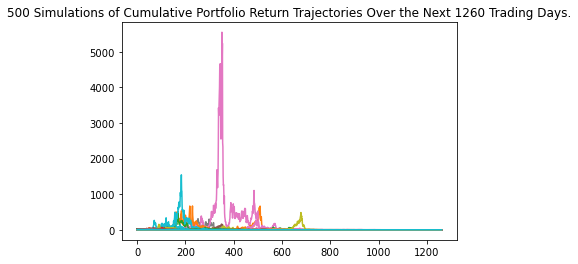

In [87]:
# Visualize the 5-year Monte Carlo simulation by creating an
# overlay line plot
MC_sim__line_plot = MC_five.plot_simulation()



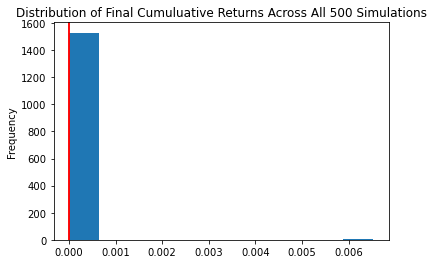

In [88]:
# Visualize the probability distribution of the 5-year Monte Carlo simulation 
# by plotting a histogram
MC_sim_line_plot = MC_five.plot_distribution()

In [89]:
# Generate summary statistics from the 5-year Monte Carlo simulation results
# Save the results as a variable
MC_summary_statistics = MC_five.summarize_cumulative_return()
MC_summary_statistics


# Review the 5-year Monte Carlo summary statistics
MC_summary_statistics

count           5.000000e+02
mean            1.754187e-05
std             2.947788e-04
min            -5.108405e-12
25%             1.306345e-15
50%             4.712855e-13
75%             2.396891e-10
max             6.526796e-03
95% CI Lower    4.864451e-21
95% CI Upper    5.393135e-06
Name: 1260, dtype: float64

In [90]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the current stock/bond portfolio
ci_lower_five_cumulative_return = MC_summary_statistics[8] * 10000
ci_upper_five_cumulative_return = MC_summary_statistics[9] * 10000

# Print the result of your calculations
print(f"There is a 95% chance that an interval investment of $10,000 in the portfolio"
f" over the next 5 years will end within the range of "
f" ${ci_lower_five_cumulative_return: .2f} and ${ci_upper_five_cumulative_return: .2f}.")

There is a 95% chance that an interval investment of $10,000 in the portfolio over the next 5 years will end within the range of  $ 0.00 and $ 0.05.


In [91]:
# Configure a Monte Carlo simulation to forecast 10 years cumulative returns
# Run 500 samples.
MC_tenyear = MCSimulation(
    portfolio_data=prices_df,
    num_simulation=500,
    num_trading_days=252*10
)

# Review the simulation input data
MC_tenyear.portfolio_data.head()


USO                                             
                            open   high    low   close    volume daily_return
time                                                                         
2017-11-10 00:00:00-05:00  11.48  11.52  11.36  11.415  11338210          NaN
2017-11-13 00:00:00-05:00  11.42  11.48  11.31  11.385  11060425    -0.002628
2017-11-14 00:00:00-05:00  11.35  11.36  11.08  11.130  19869905    -0.022398
2017-11-15 00:00:00-05:00  11.08  11.15  11.02  11.095  12784898    -0.003145
2017-11-16 00:00:00-05:00  11.07  11.17  11.03  11.080  11668773    -0.001352

In [92]:
# Run the Monte Carlo simulation to forecast 10 years cumulative returns
MC_tenyear.calc_cumulative_return()


Running Monte Carlo simulation number 0.
Running Monte Carlo simulation number 10.
Running Monte Carlo simulation number 20.
Running Monte Carlo simulation number 30.
Running Monte Carlo simulation number 40.
Running Monte Carlo simulation number 50.
Running Monte Carlo simulation number 60.
Running Monte Carlo simulation number 70.
Running Monte Carlo simulation number 80.
Running Monte Carlo simulation number 90.
Running Monte Carlo simulation number 100.
Running Monte Carlo simulation number 110.
Running Monte Carlo simulation number 120.
Running Monte Carlo simulation number 130.
Running Monte Carlo simulation number 140.
Running Monte Carlo simulation number 150.
Running Monte Carlo simulation number 160.
Running Monte Carlo simulation number 170.
Running Monte Carlo simulation number 180.
Running Monte Carlo simulation number 190.
Running Monte Carlo simulation number 200.
Running Monte Carlo simulation number 210.
Running Monte Carlo simulation number 220.
Running Monte Carlo si

0             1             2             3             4    \
0     1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
1     1.035842e+00  1.078052e+00  1.144015e+00  1.342051e+00  1.345063e+00   
2     1.251562e+00  1.173200e+00  1.068308e+00  1.427026e+00  1.644295e+00   
3     1.283989e+00  1.110077e+00  1.292802e+00  2.004151e+00  1.074457e+00   
4     1.075400e+00  9.448147e-01  1.643290e+00  1.495191e+00  1.511851e+00   
...            ...           ...           ...           ...           ...   
2516  1.687947e-26  2.165263e-36  5.793718e-14  3.137954e-21  8.090582e-32   
2517  1.555088e-26  3.026948e-36  4.941732e-14  1.762055e-21  8.458550e-32   
2518  1.187199e-26  2.737752e-36  5.728284e-14  2.113072e-21  1.018316e-31   
2519  6.042522e-27  2.604083e-36  3.988340e-14  2.637534e-21  1.048118e-31   
2520  6.024241e-27  2.034211e-36  3.275043e-14  2.533074e-21  4.190427e-32   

               5             6             7             8             9    \
0     1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
1     1.298922e+00  1.256923e+00  8.971362e-01  1.415988e+00  1.163930e+00   
2     9.594006e-01  9.360496e-01  8.194850e-01  1.867668e+00  9.490963e-01   
3     1.400226e+00  5.946161e-01  6.397461e-01  7.994172e-01  1.062947e+00   
4     1.750911e+00  5.230458e-01  6.989285e-01  5.744785e-01  1.207168e+00   
...            ...           ...           ...           ...           ...   
2516  3.579475e-25  1.403339e-26  2.903199e-34  2.818554e-20  8.997821e-21   
2517  3.468644e-25  1.122931e-26  3.002178e-34  3.728670e-20  7.449250e-21   
2518  3.185197e-25  1.122949e-26  2.316114e-34  2.997619e-20  1.019602e-20   
2519  3.787104e-25  1.080763e-26  3.241072e-34  3.442053e-20  8.832709e-21   
2520  2.977173e-25  1.016924e-26  4.392738e-34  4.310520e-20  7.325527e-21   

      ...           490           491           492           493  \
0     ...  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
1     ...  9.151808e-01  1.015603e+00  9.359127e-01  1.222520e+00   
2     ...  6.764464e-01  7.055557e-01  6.989658e-01  1.296796e+00   
3     ...  5.894320e-01  6.690374e-01  6.766397e-01  1.371778e+00   
4     ...  4.220650e-01  5.860746e-01  8.580217e-01  1.209022e+00   
...   ...           ...           ...           ...           ...   
2516  ... -7.155231e-19  1.884218e-23  1.078824e-23  2.009401e-20   
2517  ... -8.825020e-19  2.011225e-23  8.545382e-24  1.842851e-20   
2518  ... -9.239695e-19  2.572798e-23  5.195705e-24  1.735343e-20   
2519  ... -1.062855e-18  2.266243e-23  4.564392e-24  2.166257e-20   
2520  ... -8.781419e-19  1.960241e-23  4.623721e-24  2.197519e-20   

               494           495           496           497           498  \
0     1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
1     9.304784e-01  1.324234e+00  4.988971e-01  9.442648e-01  1.326258e+00   
2     1.110142e+00  1.433350e+00  4.500407e-01  1.160718e+00  1.232469e+00   
3     1.439428e+00  1.377543e+00  3.620511e-01  1.209019e+00  8.682322e-01   
4     1.660156e+00  1.772115e+00  2.452557e-01  1.471159e+00  7.876370e-01   
...            ...           ...           ...           ...           ...   
2516  7.049702e-26  3.816570e-23  4.109320e-32  7.439294e-29  3.790616e-30   
2517  3.640225e-26  3.895538e-23  2.851456e-32  4.990752e-29  3.761283e-30   
2518  3.329090e-26  4.684609e-23  2.289515e-32  5.235016e-29  2.232931e-30   
2519  3.755992e-26  5.840323e-23  1.668395e-32  3.655452e-29  2.356032e-30   
2520  4.572580e-26  4.402800e-23  1.705961e-32  3.262363e-29  1.884072e-30   

               499  
0     1.000000e+00  
1     7.818333e-01  
2     7.884602e-01  
3     9.378203e-01  
4     9.411005e-01  
...            ...  
2516  4.194917e-24  
2517  4.452409e-24  
2518  4.337328e-24  
2519  3.884243e-24  
2520  4.163251e-24  

[2521 rows x 500 columns]

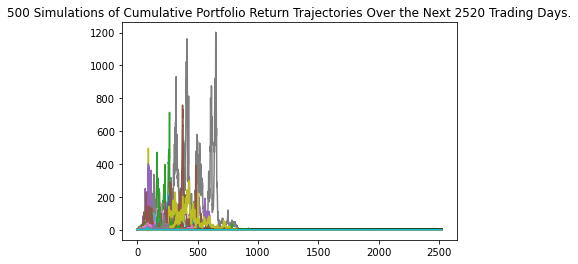

In [93]:
# Visualize the 10-year Monte Carlo simulation by creating an
# overlay line plot
MC_sim__line_plot = MC_tenyear.plot_simulation()


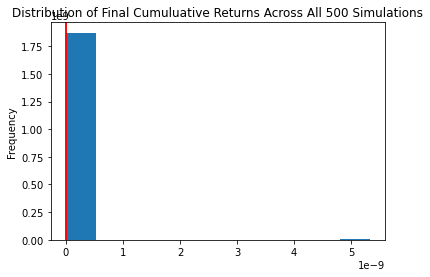

In [94]:
# Visualize the probability distribution of the 10-year Monte Carlo simulation 
# by plotting a histogram
MC_sim__line_plot = MC_tenyear.plot_distribution()

In [95]:
# Generate summary statistics from the 10-year Monte Carlo simulation results
# Save the results as a variable
MC_summary_statistics_ten = MC_tenyear.summarize_cumulative_return()
MC_summary_statistics_ten


# Review the 10-year Monte Carlo summary statistics
MC_summary_statistics_ten

count           5.000000e+02
mean            1.072554e-11
std             2.383736e-10
min            -8.781419e-19
25%             2.017758e-29
50%             1.534302e-25
75%             6.130094e-22
max             5.330230e-09
95% CI Lower    5.520586e-38
95% CI Upper    1.304417e-14
Name: 2520, dtype: float64

In [96]:
# Use the lower and upper `95%` confidence intervals to calculate the range of the possible outcomes for the current stock/bond portfolio
ci_lower_ten_cumulative_return = MC_summary_statistics_ten[8] * 10000
ci_upper_ten_cumulative_return = MC_summary_statistics_ten[9] * 10000

# Print the result of your calculations
print(f"There is a 95% chance that an interval investment of $10,000 in the portfolio"
f" over the next five years will end within the range of "
f" ${ci_lower_ten_cumulative_return: .2f} and ${ci_upper_ten_cumulative_return: .2f}.")

There is a 95% chance that an interval investment of $10,000 in the portfolio over the next five years will end within the range of  $ 0.00 and $ 0.00.


In [97]:
# The current volume of shares for each company.
TSLA_shares = 100
USO_shares = 100
SPY_shares = 100

In [98]:
# Set the tickers for both the bond and stock portion of the portfolio
tickers = ["TSLA", "USO", "SPY"]
# Set timeframe to 1D 
timeframe = "1D"

In [104]:
# Import the data by reading in the CSV file and setting the DatetimeIndex 
# Review the first 5 rows of eadh DataFrame
TSLA_navs_f = Path('../Project1/TSLA.csv')
TSLA_navs_df = pd.read_csv(TSLA_navs_f, infer_datetime_format=True, index_col='Date', parse_dates=True)

In [105]:
USO_navs_f = Path('../Project1/USO.csv')
USO_navs_df = pd.read_csv(USO_navs_f, infer_datetime_format=True, index_col='Date', parse_dates=True)

In [106]:
SPY_navs_f = Path('../Project1/SPY.csv')
SPY_navs_df = pd.read_csv(SPY_navs_f, infer_datetime_format=True, index_col='Date', parse_dates=True)

In [107]:
# Access the closing price for AGG from the Alpaca DataFrame
# Converting the value to a floating point number
TSLA_close_price = TSLA_navs_df["Close"]
TSLA_close_price

# Print the AGG closing price
print(TSLA_close_price)

Date
2010-11-09       4.926000
2010-11-10       5.872000
2010-11-11       5.608000
2010-11-12       5.968000
2010-11-15       6.160000
                 ...     
2021-11-02    1172.000000
2021-11-03    1213.859985
2021-11-04    1229.910034
2021-11-05    1222.089966
2021-11-08    1162.939941
Name: Close, Length: 2769, dtype: float64


In [108]:
# Access the closing price for SPY from the Alpaca DataFrame
# Converting the value to a floating point number
USO_close_price = USO_navs_df["Close"]
USO_close_price

# Print the SPY closing price
print(USO_close_price)


Date
2010-11-09    296.399994
2010-11-10    304.320007
2010-11-11    302.720001
2010-11-12    291.760010
2010-11-15    292.000000
                 ...    
2021-11-02     57.529999
2021-11-03     55.340000
2021-11-04     54.919998
2021-11-05     56.549999
2021-11-08     57.090000
Name: Close, Length: 2769, dtype: float64


In [109]:
# Access the closing price for SPY from the Alpaca DataFrame
# Converting the value to a floating point number
SPY_close_price = SPY_navs_df["Close"]
SPY_close_price

# Print the SPY closing price
print(SPY_close_price)


Date
2010-11-09    121.610001
2010-11-10    122.099998
2010-11-11    121.639999
2010-11-12    120.199997
2010-11-15    120.029999
                 ...    
2021-11-02    461.899994
2021-11-03    464.720001
2021-11-04    466.910004
2021-11-05    468.529999
2021-11-08    468.929993
Name: Close, Length: 2769, dtype: float64


In [110]:
# Calculate the current value of the bond portion of the portfolio
TSLA_value_recent = TSLA_close_price[-1] * TSLA_shares
TSLA_value_recent

# Print the current value of the bond portfolio
print(f"The current value of TSLA stock is ${TSLA_value_recent}")


The current value of TSLA stock is $116293.99410000001


In [111]:
# Calculate the current value of the bond portion of the portfolio
TSLA_value_middle = TSLA_close_price[-1384] * TSLA_shares
TSLA_value_middle

# Print the current value of the bond portfolio
print(f"The value of TSLA stock in the middle of 2015 is ${TSLA_value_middle}")

The value of TSLA stock in the middle of 2015 is $4145.6001


In [112]:
# Calculate the current value of the bond portion of the portfolio
TSLA_value_early = TSLA_close_price[-2700] * TSLA_shares
TSLA_value_early

# Print the current value of the bond portfolio
print(f"The early value of TSLA stock is ${TSLA_value_early}")

The early value of TSLA stock is $472.0


In [113]:
# Calculate the current value of the stock portion of the portfolio
USO_value_recent = USO_close_price[-1] * USO_shares
USO_value_recent

# Print the current value of the stock portfolio
print(f"The current value of the USO stock is ${USO_value_recent}")

The current value of the USO stock is $5709.0


In [114]:
# Calculate the current value of the stock portion of the portfolio
USO_value_middle = USO_close_price[-1384] * USO_shares
USO_value_middle

# Print the current value of the stock portfolio
print(f"The value of the USO stock in the middle of 2015 is ${USO_value_middle}")

The value of the USO stock in the middle of 2015 is $9159.9998


In [115]:
# Calculate the current value of the stock portion of the portfolio
USO_value_early = USO_close_price[-2700] * USO_shares
USO_value_early

# Print the current value of the stock portfolio
print(f"The early value of the USO stock is ${USO_value_early}")

The early value of the USO stock is $28848.001099999998


In [116]:
# Calculate the current value of the stock portion of the portfolio
SPY_value_recent = SPY_close_price[-1] * SPY_shares
SPY_value_recent

# Print the current value of the stock portfolio
print(f"The current vale of the SPY stock is ${SPY_value_recent}")

The current vale of the SPY stock is $46892.9993


In [117]:
# Calculate the current value of the stock portion of the portfolio
SPY_value_middle = SPY_close_price[-1384] * SPY_shares
SPY_value_middle

# Print the current value of the stock portfolio
print(f"The value of the SPY stock in the middle of 2015 is ${SPY_value_middle}")

The value of the SPY stock in the middle of 2015 is $20655.9998


In [118]:
# Calculate the current value of the stock portion of the portfolio
SPY_value_early = SPY_close_price[-2700] * SPY_shares
SPY_value_early

# Print the current value of the stock portfolio
print(f"The early value of the SPY stock is ${SPY_value_early}")

The early value of the SPY stock is $13425.0


In [119]:
display(type('Close'))
TSLA_df = pd.DataFrame(data= TSLA_navs_df, columns=['Close'])
display(TSLA_df)

str

Close
Date                   
2010-11-09     4.926000
2010-11-10     5.872000
2010-11-11     5.608000
2010-11-12     5.968000
2010-11-15     6.160000
...                 ...
2021-11-02  1172.000000
2021-11-03  1213.859985
2021-11-04  1229.910034
2021-11-05  1222.089966
2021-11-08  1162.939941

[2769 rows x 1 columns]

In [120]:
display(type('Close'))
USO_df = pd.DataFrame(data= USO_navs_df, columns=['Close'])
display(USO_df)

str

Close
Date                  
2010-11-09  296.399994
2010-11-10  304.320007
2010-11-11  302.720001
2010-11-12  291.760010
2010-11-15  292.000000
...                ...
2021-11-02   57.529999
2021-11-03   55.340000
2021-11-04   54.919998
2021-11-05   56.549999
2021-11-08   57.090000

[2769 rows x 1 columns]

In [121]:
display(type('Close'))
SPY_df = pd.DataFrame(data= SPY_navs_df, columns=['Close'])
display(SPY_df)

str

Close
Date                  
2010-11-09  121.610001
2010-11-10  122.099998
2010-11-11  121.639999
2010-11-12  120.199997
2010-11-15  120.029999
...                ...
2021-11-02  461.899994
2021-11-03  464.720001
2021-11-04  466.910004
2021-11-05  468.529999
2021-11-08  468.929993

[2769 rows x 1 columns]

In [122]:
recent_price_df = [
    TSLA_value_recent,
    USO_value_recent, 
    SPY_value_recent
]
display(recent_price_df)

[116293.99410000001, 5709.0, 46892.9993]

In [123]:
recent_price_pddf = pd.DataFrame(
    data=recent_price_df,
    index=['TSLA','USO','SPY'],
    columns=['Close']
)
recent_price_pddf
display(recent_price_pddf)

Close
TSLA  116293.9941
USO     5709.0000
SPY    46892.9993

In [124]:
middle_price_df = [
    TSLA_value_middle, 
    USO_value_middle, 
    SPY_value_middle
]
display(middle_price_df)

[4145.6001, 9159.9998, 20655.9998]

In [125]:
middle_price_pddf = pd.DataFrame(
    data=middle_price_df,
    index=['TSLA', 'USO', 'SPY'],
    columns=['Close']
)
display(middle_price_pddf)

Close
TSLA   4145.6001
USO    9159.9998
SPY   20655.9998

In [126]:
early_price_df = [
    TSLA_value_early,
    USO_value_early,
    SPY_value_early
]
display(early_price_df)

[472.0, 28848.001099999998, 13425.0]

In [127]:
early_price_pddf = pd.DataFrame(
    data=early_price_df,
    index=['TSLA', 'USO', 'SPY'],
    columns=['Close']
)
display(early_price_pddf)

Close
TSLA    472.0000
USO   28848.0011
SPY   13425.0000

<AxesSubplot:title={'center':'Value of TSLA, USO, and SPY stock prices at the beginning of 2010'}, ylabel='Close'>

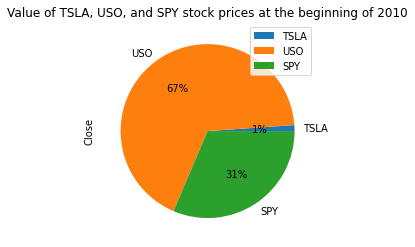

In [128]:

early_price_pddf.plot.pie(y='Close', title='Value of TSLA, USO, and SPY stock prices at the beginning of 2010', autopct='%1.0f%%')

#If a person were to take $10,000 and invest it in the three stocks with equal number of shares for each, 67% of the purchase would be USO stock.

<AxesSubplot:title={'center':'Value of TSLA, USO, and SPY stocks in the middle of 2015'}, ylabel='Close'>

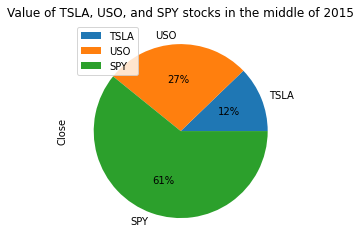

In [129]:

middle_price_pddf.plot.pie(y='Close', title='Value of TSLA, USO, and SPY stocks in the middle of 2015', autopct='%1.0f%%')

#By the middle of 2015, the percentage of the three stock prices would show that out of the original $10,000, 61% of the purchase would be SPY stock.

<AxesSubplot:title={'center':'Most Recent(07/11/2021) value of TSLA, USO, and SPY Stocks'}, ylabel='Close'>

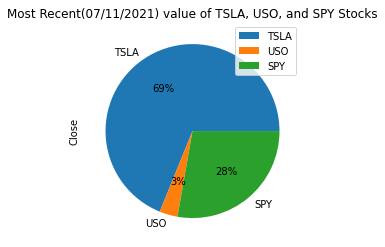

In [130]:
recent_price_pddf.plot.pie(y='Close', title='Most Recent(07/11/2021) value of TSLA, USO, and SPY Stocks', autopct='%1.0f%%')
 

#Finally in our most recent pie chart, after adjusted prices have been accounted for, the originall $10,000 would be 69% TSLA stock.

In [131]:
SPY_df = SPY_navs_df
SPY_df['return'] = SPY_df['Adj Close'].pct_change().fillna(0)

In [136]:
SPY_mc = SPY_df['return'].montecarlo(sims=500, bust=-0.1, goal=1)

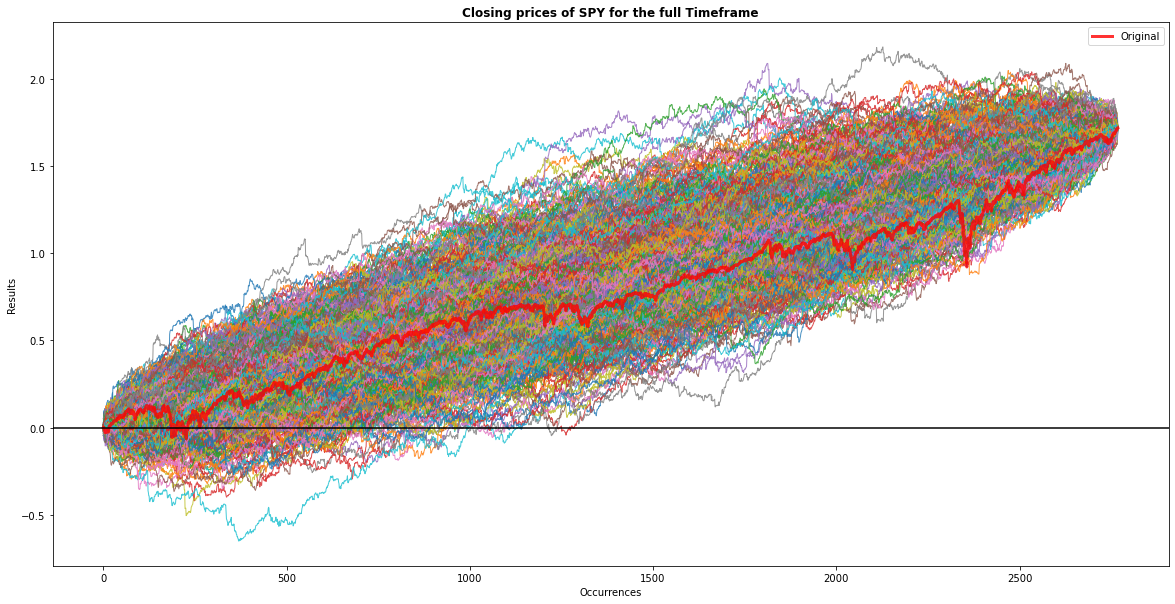

In [137]:
SPY_mc.plot(title="Closing prices of SPY for the full Timeframe", figsize=(20,10))

In [138]:
print(SPY_mc.stats)

{'min': 1.720060424131839, 'max': 1.720060424131852, 'mean': 1.7200604241318376, 'median': 1.7200604241318453, 'std': 8.094266547235958e-15, 'maxdd': -0.6512239590293291, 'bust': 0.288, 'goal': 0.712}


In [139]:
print(SPY_mc.data.head())

   original         1         2         3         4         5         6  \
0  0.000000  0.002984 -0.001045  0.001915  0.002427  0.010479  0.006763   
1  0.004029  0.002249 -0.013372  0.004147  0.000317  0.009313  0.003815   
2 -0.003768 -0.005847 -0.006024 -0.000068 -0.020489  0.000048 -0.001839   
3 -0.011838  0.002429  0.000212 -0.001106  0.005889  0.002013  0.001482   
4 -0.001414  0.008069 -0.025098  0.008096 -0.001554 -0.014541 -0.003089   

          7         8         9  ...       490       491       492       493  \
0 -0.004439 -0.009957  0.002433  ... -0.001466  0.000906 -0.014831  0.007138   
1  0.003470  0.004210  0.008654  ...  0.002532 -0.020881  0.001024  0.021268   
2  0.002601 -0.004477 -0.001414  ... -0.000054  0.006893 -0.001175  0.005744   
3 -0.001621  0.001440 -0.001681  ... -0.001363 -0.001671  0.008783 -0.000164   
4 -0.009923  0.004487  0.000227  ...  0.006867 -0.007871  0.005805  0.010698   

        494       495       496       497       498       499  
0  0

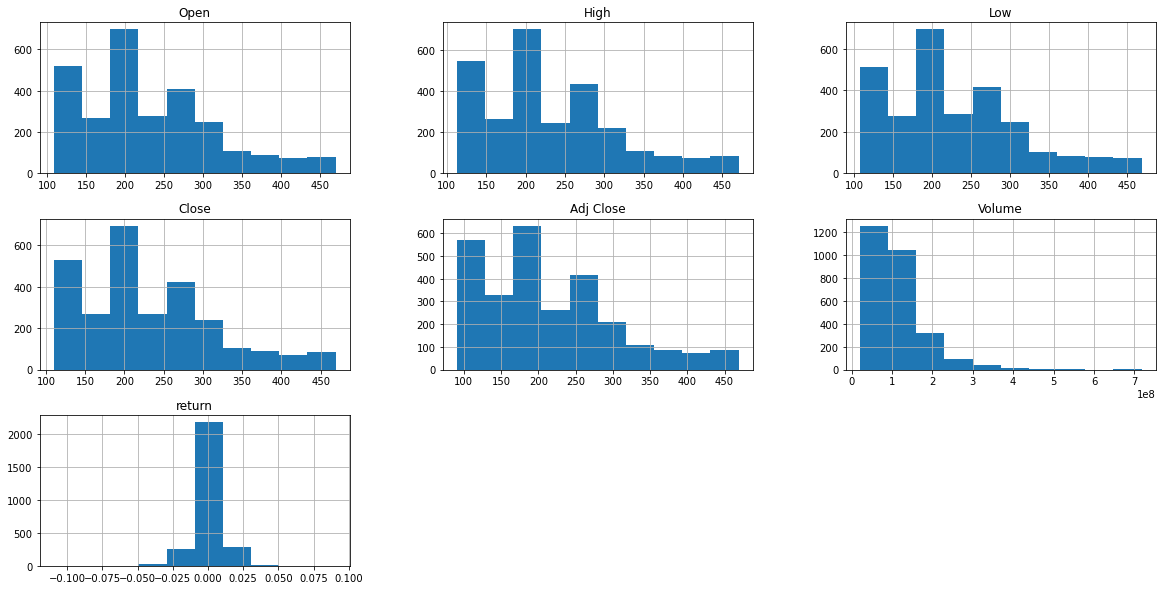

In [140]:
SPY_mc_sim_line_plot = SPY_df.hist(figsize=(20,10))

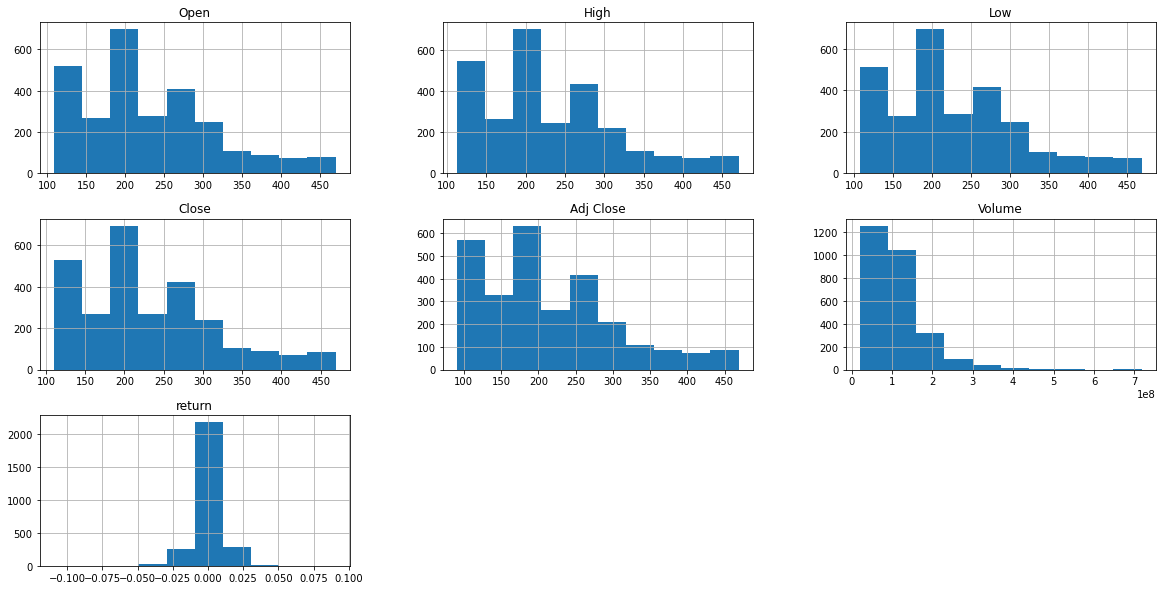

In [141]:
SPY_mc_sim_line_plot = SPY_df.hist(figsize=(20,10))

In [142]:
#cumulative sum for 100 shares of SPY
SPY_df.cumsum()

Open           High            Low          Close  \
Date                                                                     
2010-11-09     122.820000     122.949997     121.120003     121.610001   
2010-11-10     244.400002     245.110001     241.780007     243.709999   
2010-11-11     365.450005     366.930001     362.460007     365.349998   
2010-11-12     486.270005     488.279999     482.110009     485.549995   
2010-11-15     606.850007     609.330002     602.090012     605.579994   
...                   ...            ...            ...            ...   
2021-11-02  639008.340086  642208.699775  635521.309985  639123.749730   
2021-11-03  639469.640074  642673.849769  635982.139972  639588.469731   
2021-11-04  639935.000059  643140.849769  636447.129962  640055.379735   
2021-11-05  640404.280058  643611.499763  636914.049975  640523.909734   
2021-11-08  640873.980070  644081.729774  637382.249987  640992.839727   

                Adj Close        Volume    return  
Date                                               
2010-11-09      98.179329     186621600  0.000000  
2010-11-10     196.754234     408009000  0.004029  
2010-11-11     294.957756     566026600  0.000262  
2010-11-12     391.998726     805095400 -0.011577  
2010-11-15     488.902466     969036200 -0.012991  
...                   ...           ...       ...  
2021-11-02  590337.189617  312805405000  1.704919  
2021-11-03  590801.909618  312857914800  1.711025  
2021-11-04  591268.819622  312910761900  1.715737  
2021-11-05  591737.349621  312977094100  1.719207  
2021-11-08  592206.279614  313027499300  1.720060  

[2769 rows x 7 columns]

In [143]:
TSLA_df = TSLA_navs_df
TSLA_df['return'] = TSLA_df['Adj Close'].pct_change().fillna(0)

In [144]:
TSLA_mc = TSLA_df['return'].montecarlo(sims=500, bust=-0.1, goal=1)

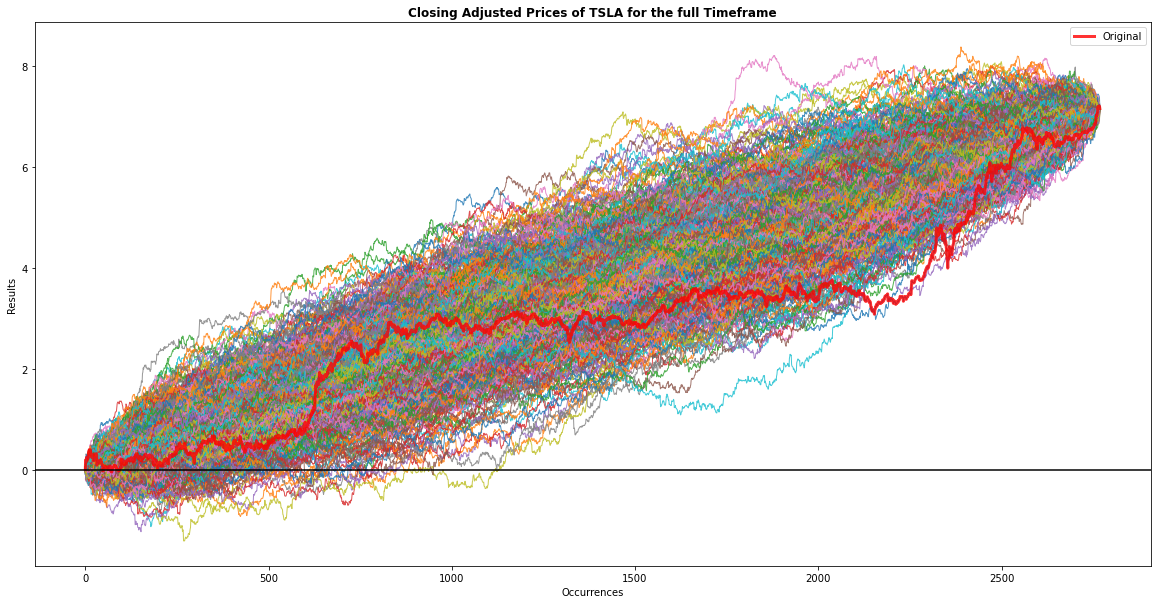

In [145]:
TSLA_mc.plot(title="Closing Adjusted Prices of TSLA for the full Timeframe", figsize=(20,10))

In [146]:
print(TSLA_mc.stats)

{'min': 7.159553061758615, 'max': 7.159553061758672, 'mean': 7.159553061758707, 'median': 7.159553061758643, 'std': 6.504046934054775e-14, 'maxdd': -1.4178365129759412, 'bust': 0.56, 'goal': 0.44}


In [147]:
print(TSLA_mc.data.head())

   original         1         2         3         4         5         6  \
0  0.000000 -0.005112 -0.050438  0.010635  0.056582 -0.034591  0.050832   
1  0.192042  0.001757 -0.004449 -0.003127 -0.072254  0.003275 -0.006866   
2 -0.044959 -0.028681  0.013222  0.036867 -0.012119  0.013307 -0.013089   
3  0.064194  0.071827 -0.022636  0.029725  0.003413 -0.049776  0.020867   
4  0.032172 -0.011533  0.048406 -0.017209  0.003155  0.011000  0.000578   

          7         8         9  ...       490       491       492       493  \
0 -0.000257 -0.007323  0.019122  ...  0.125689 -0.009449  0.091369  0.011801   
1 -0.018417 -0.016440  0.002618  ... -0.032831  0.061398 -0.033510  0.007410   
2  0.029130  0.002178  0.003155  ... -0.017200  0.025230  0.016054  0.027076   
3 -0.056514  0.157385  0.102962  ...  0.036867  0.031132 -0.030255  0.006677   
4  0.002374  0.003101  0.007717  ... -0.013186 -0.011780  0.019272  0.009361   

        494       495       496       497       498       499  
0 -0

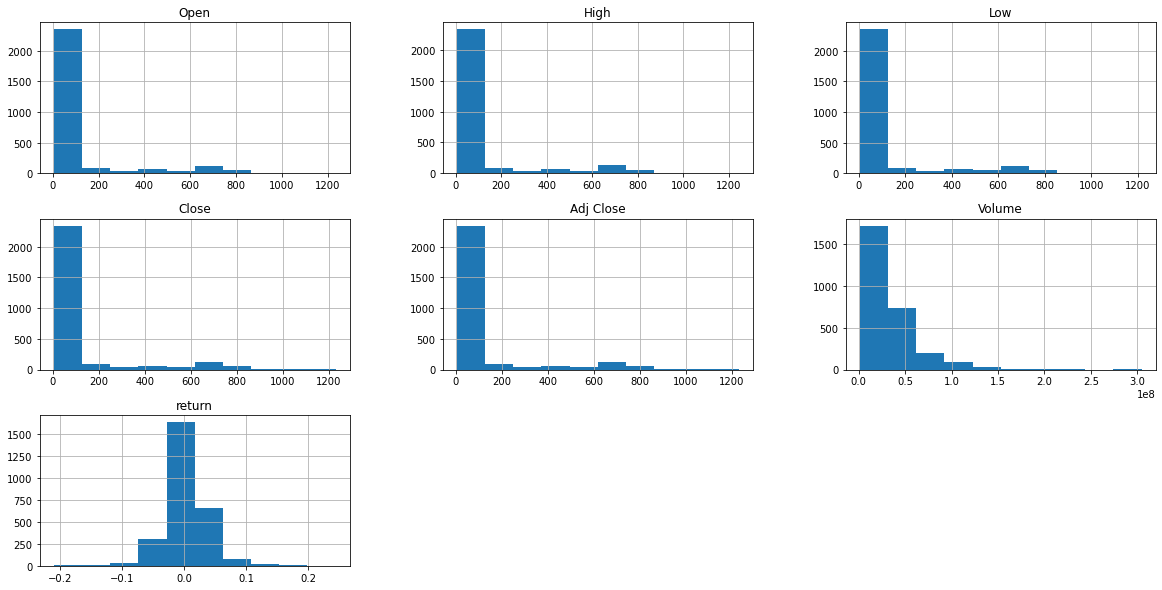

In [148]:
TSLA_mc_sim_line_plot = TSLA_df.hist(figsize=(20,10))

In [149]:
#cumulative sum for 100 shares of TSLA
TSLA_df.cumsum()

Open           High            Low          Close  \
Date                                                                     
2010-11-09       5.000000       5.138000       4.810000       4.926000   
2010-11-10       9.896000      11.132000       9.620000      10.798000   
2010-11-11      15.616000      16.952000      15.086000      16.406000   
2010-11-12      21.266000      23.052000      20.700000      22.374000   
2010-11-15      27.310000      29.640000      26.744000      28.534000   
...                   ...            ...            ...            ...   
2021-11-02  313251.402356  319854.175769  306556.856139  313673.451616   
2021-11-03  314428.732312  321069.565784  307709.476134  314887.311601   
2021-11-04  315663.142346  322313.055774  308926.476134  316117.221635   
2021-11-05  316891.142346  323552.925769  310134.476134  317339.311601   
2021-11-08  318040.932385  324749.925769  311267.476134  318502.251542   

                Adj Close       Volume    return  
Date                                              
2010-11-09       4.926000      4782000  0.000000  
2010-11-10      10.798000     20084500  0.192042  
2010-11-11      16.406000     29811000  0.147083  
2010-11-12      22.374000     43456500  0.211277  
2010-11-15      28.534000     56571000  0.243449  
...                   ...          ...       ...  
2021-11-02  313673.451616  89218310900  7.165373  
2021-11-03  314887.311601  89252939400  7.201090  
2021-11-04  316117.221635  89278336800  7.214312  
2021-11-05  317339.311601  89299916700  7.207954  
2021-11-08  318502.251542  89333362400  7.159553  

[2769 rows x 7 columns]

In [150]:
USO_df = USO_navs_df
USO_df['return'] = USO_df['Adj Close'].pct_change().fillna(0)

In [151]:
USO_mc = USO_df['return'].montecarlo(sims=500, bust=-0.1, goal=1)

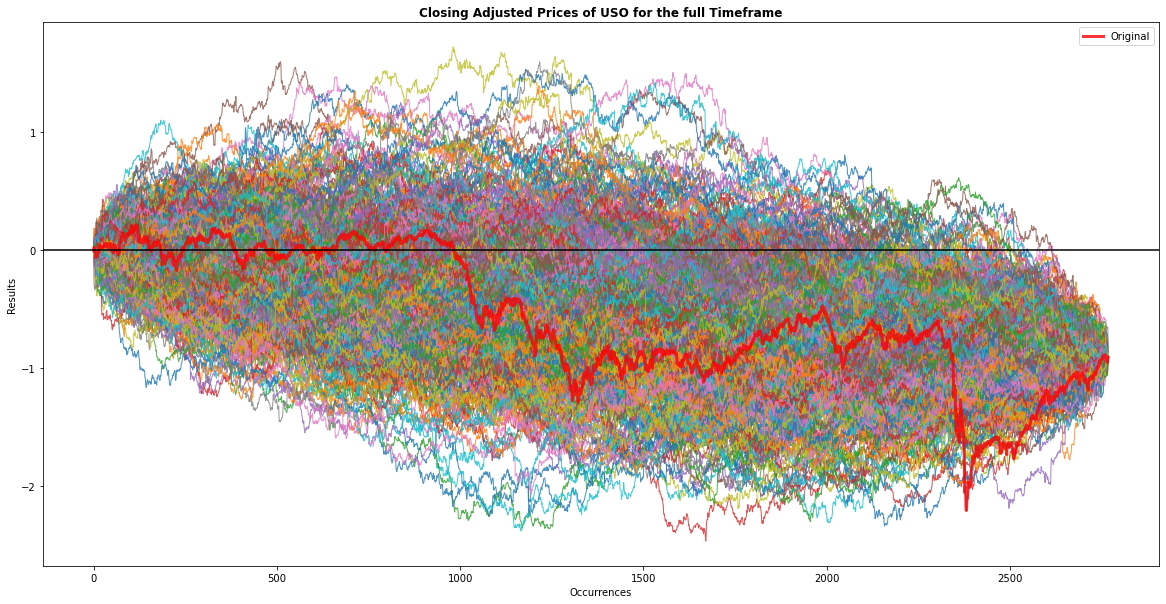

In [152]:
USO_mc.plot(title="Closing Adjusted Prices of USO for the full Timeframe", figsize=(20,10))

In [153]:
print(USO_mc.stats)

{'min': -0.9099356556604171, 'max': -0.9099356556604052, 'mean': -0.9099356556604188, 'median': -0.9099356556604115, 'std': 7.521241797345566e-15, 'maxdd': -2.4701657946862374, 'bust': 1.0, 'goal': 0.0}


In [154]:
print(USO_mc.data.head())

   original         1         2         3         4         5         6  \
0  0.000000  0.008525  0.028000  0.002726  0.001115  0.013934  0.015401   
1  0.026721  0.001359 -0.001428  0.038344 -0.013667  0.004098 -0.031576   
2 -0.005258 -0.000315  0.024434 -0.022635  0.002039  0.017288 -0.015087   
3 -0.036205  0.025057  0.024410  0.001009  0.008951  0.020567  0.030009   
4  0.000823  0.011494 -0.000959  0.001748 -0.000256  0.002889 -0.020175   

          7         8         9  ...       490       491       492       493  \
0 -0.012484  0.003769 -0.015598  ... -0.007498 -0.008965 -0.015594  0.000000   
1 -0.022038 -0.003451 -0.002315  ...  0.006986  0.005691  0.005459  0.009574   
2 -0.005900 -0.004440 -0.003698  ... -0.018660 -0.033065  0.001630 -0.008278   
3 -0.013112 -0.015163 -0.067967  ... -0.008789  0.004630  0.022356  0.013973   
4  0.025600 -0.033782  0.016394  ...  0.007312 -0.005044  0.002974 -0.031430   

        494       495       496       497       498       499  
0 -0

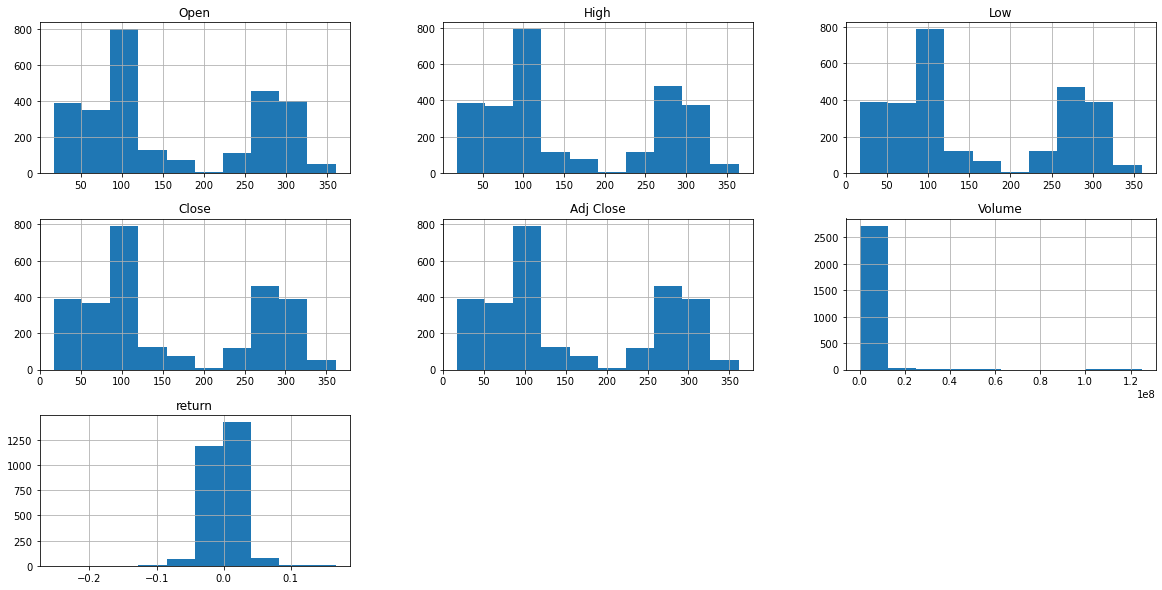

In [155]:
USO_mc_sim_line_plot = USO_df.hist(figsize=(20,10))